## Create notebook performing RK integration for multiple coupled variables

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### Define coupled variables to integrate

In [18]:
def dydx(x,y):
    
    # Set the derivatives
    
    # Eqn is d^2y/dx^2 = -y
    
    # So we write
    # dydx = z
    # dzdx = -y
    
    # Set y = y[0]
    # Set z = y[1]
    
    # Declare array
    y_derivs = np.zeros(2)
    
    # Set dydx
    y_derivs[0] = y[1]
    
    # Set dzdx = -y
    y_derivs[1] = -1*y[0]
    
    # Return an array
    return y_derivs

### Define 4th order RK method for multiple variables

In [19]:
def rk4_mv_core(dydx, xi, yi, nv, h):
    
    # Declare k? arrays
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    
    # Define x at 1/2 step
    x_ipoh = xi + 0.5*h
    
    # Define x at 1 step
    x_ipo = xi + h
    
    # Declare a temp y array
    y_temp = np.zeros(nv)
    
    # Get k1 values
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs[:]
    
    # Get k2 values
    y_temp[:] = yi[:] + 0.5*k1[:]
    y_derivs = dydx(x_ipoh, y_temp)
    k2[:] = h*y_derivs[:]
    
    # Get k3 values
    y_temp[:] = yi[:] + 0.5*k2[:]
    y_derivs = dydx(x_ipoh, y_temp)
    k3[:] = h*y_derivs[:]
    
    # Get k4 values
    y_temp[:] = yi[:] + k3[:]
    y_derivs = dydx(x_ipo, y_temp)
    k4[:] = h*y_derivs[:]
    
    # Advance y by a step h
    yipo = yi + (k1 + 2*k2 + 2*k3 + k4)/6.
     
    return yipo

## Define an adaptive step size driver for RK4

In [20]:
def rk4_mv_ad(dydx, x_i, y_i, nv, h, tol):
    
    # Define safety scale
    SAFETY    = 0.9
    H_NEW_FAC = 2.0
    
    # Set max # of iterations
    imax = 10000
    
    # Set iteration variable
    i = 0
    
    # Create an error
    Delta = np.full(nv, 2*tol)
    
    # Remember the current step
    h_step = h
    
    # Adjust step if necessary
    while(Delta.max()/tol > 1.0):
        
        # Estimate our error by takine one step of size h
        # vs. two steps of size h/2
        y_2 = rk4_mv_core(dydx, x_i, y_i, nv, h_step)
        y_1 = rk4_mv_core(dydx, x_i, y_i, nv, 0.5*h_step)
        y_11 = rk4_mv_core(dydx, x_i + 0.5*h_step, y_1, nv, 0.5*h_step)
        
        # Compute an error
        Delta = np.fabs(y_2 - y_11)
        
        # If error's too large, take smaller step
        if(Delta.max()/tol > 1.0):
            
            # Error too large, decrease step
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
                
        # Check iteration
        if(i>=imax):
            print("Too many iterations in rk4_mv_ad()")
            raise StopIteration("Ending after i = ", i)
                
        # Iterate
        i += 1
            
    # Next time, try to take bigger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
        
    # Return answer, a new step and step we actually took
    return y_2, h_new, h_step

## Define wrapper for RK4

In [21]:
def rk4_mv(dydx, a, b, y_a, tol):
    
    # dfdx is derivative wrt x
    # a is lower bound
    # b is upper bound
    # y_a are boundary conditions
    # tol is tolerance for integrating y
    
    # Define starting step
    xi = a
    yi = y_a.copy()
    
    # An initial step size == make very small
    h = 1.0e-4 * (b-a)
    
    # Set max # of iterations
    imax = 10000
    
    # Set iteration variable
    i = 0
    
    # Set # of coupled ODEs to size of y_a
    nv = len(y_a)
    
    # Set initial conditions
    x = np.full(1,a)
    y = np.full((1,nv), y_a)
    
    # Set a flag
    flag = 1
    
    # Loop until we reach right side
    while(flag):
        
        # Calculate y_i+1 using adaptive step
        yi_new, h_new, h_step = rk4_mv_ad(dydx, xi, yi, nv, h, tol)
        
        # Update the step
        h = h_new
        
        # Prevent on overshoot
        if(xi+h_step > b):
            
            # Take a smaller step
            h = b-xi
            
            # Recalculate y_i+1
            yi_new, h_new, h_step = rk4_mv_ad(dydx, xi, yi, nv, h, tol)
            
            # Break
            flag = 0
            
        # Update values
        xi += h_step
        yi[:] = yi_new[:]
        
        # Add step to the arrays
        x = np.append(x, xi)
        y_new = np.zeros((len(x), nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
        
        # Prevent too many iterations
        if(i >= imax):
            
            print("Maximum iterations reached.")
            raise StopIteration("Iteration number = ", i)
            
        # Iterate
        i += 1
        
        # Output some information
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb = %9.8f" % (i, xi, h_step, b)
        print(s)
        
        # Break if new xi is == b
        if(xi == b):
            flag = 0
            
    # Return the answer
    return x,y
    

## Perform integration

In [22]:
a = 0.0
b = 2.0 * np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

# Perform integration
x,y = rk4_mv(dydx, a, b, y_0, tolerance)

i =   1	x = 0.00062832	h = 0.00062832	b = 6.28318531
i =   2	x = 0.00188496	h = 0.00125664	b = 6.28318531
i =   3	x = 0.00439823	h = 0.00251327	b = 6.28318531
i =   4	x = 0.00942478	h = 0.00502655	b = 6.28318531
i =   5	x = 0.01947787	h = 0.01005310	b = 6.28318531
i =   6	x = 0.03958407	h = 0.02010619	b = 6.28318531
i =   7	x = 0.07979645	h = 0.04021239	b = 6.28318531
i =   8	x = 0.16022123	h = 0.08042477	b = 6.28318531
i =   9	x = 0.32107077	h = 0.16084954	b = 6.28318531
i =  10	x = 0.46816761	h = 0.14709684	b = 6.28318531
i =  11	x = 0.60535502	h = 0.13718741	b = 6.28318531
i =  12	x = 0.74522296	h = 0.13986794	b = 6.28318531
i =  13	x = 0.88873209	h = 0.14350913	b = 6.28318531
i =  14	x = 1.02700188	h = 0.13826979	b = 6.28318531
i =  15	x = 1.16350434	h = 0.13650247	b = 6.28318531
i =  16	x = 1.29828215	h = 0.13477781	b = 6.28318531
i =  17	x = 1.43207856	h = 0.13379641	b = 6.28318531
i =  18	x = 1.56536018	h = 0.13328163	b = 6.28318531
i =  19	x = 1.69861470	h = 0.13325451	b = 6.28

## Plot the result

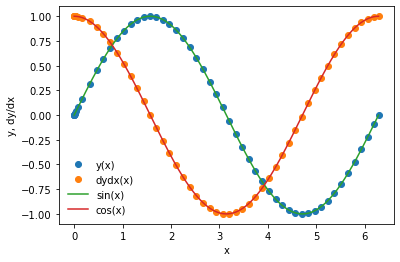

In [23]:
# Plotting y first
plt.plot(x, y[:,0], 'o', label='y(x)')

# Plot z second
plt.plot(x, y[:,1], 'o', label='dydx(x)')

xx = np.linspace(0, 2.0 * np.pi, 1000)
plt.plot(xx, np.sin(xx), label='sin(x)')
plt.plot(xx, np.cos(xx), label='cos(x)')

plt.xlabel('x')
plt.ylabel('y, dy/dx')

plt.legend(frameon=False)

## Plot the Error

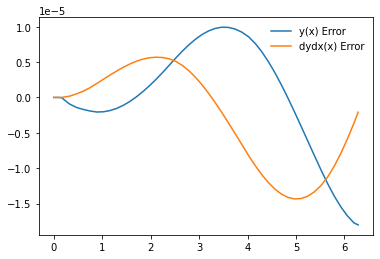

In [24]:
sine = np.sin(x)
cosine = np.cos(x)

y_error = (y[:,0] - sine)
dydx_error = (y[:,1] - cosine)

plt.plot(x, y_error, label="y(x) Error")
plt.plot(x, dydx_error, label="dydx(x) Error")

plt.legend(frameon=False)
